In [1]:
import numpy as np
from scipy import interpolate
import time
import math
import matplotlib.pyplot as plt
# from misc.golden_section_search import Search

In [2]:
"""
Michael Pham
February 2025

much thanks, heavy inspiration from Prof. Heer from Ch. 10.1.2 in Heer/Maussner, Dynamic General Equilibrium Modeling: Computational
Methods and Applications, Algorithm 10.1.1

version 4 with K, Z, H, L (solved endogenously) state variable
no consumption tax
"""

'\nMichael Pham\nFebruary 2025\n\nmuch thanks, heavy inspiration from Prof. Heer from Ch. 10.1.2 in Heer/Maussner, Dynamic General Equilibrium Modeling: Computational\nMethods and Applications, Algorithm 10.1.1\n\nversion 4 with K, Z, H, L (solved endogenously) state variable\nno consumption tax\n'

In [3]:
exp = np.e
log = math.log

In [4]:
# Parameters - households and firms
beta = 0.935  # discount factor
eta = 2.0    # coefficient of relative risk aversion
gamma = 2  # disutility from working
alpha = 0.33 # capital share in production
delta = 0.1  # depreciation rate
# omega = 0.1  # parent education time factor
phi_p = 0.324  # share of parental input in education
psi_e = 0.29  # CES parameter for education inputs
theta_I = 0.5  # human capital investment effectiveness
varsigma_g = 1
varsigma_p = 1


# phi_p = 0.324
# varsigma_p = 1
# varsigma_g = 1
# theta_I = 0.5
# psi_e = 0.29
# I_e = (0.06 * Y)
# I_e_mean = (0.035*Y)
# e_mean = 0.01
# e_min = 0.001
# e_max = 1





tfp = 1      #total factor productivity
small = 0.00001
neg = -1e10

#Parameters - government
tau = 0.15
Ie_gdp = 0.06 # public education investment as percent of GDP
Iz_gdp = 0.06 # public infrastructure investment as percent of GDP percent of GDP
sigma_bar = 0.3  # public investment inefficiency
G_gdp = 0.07      # grants (as a fraction of GDP)
psi = 0.1   # public infrastructure elasticity
# nu = 0.6     # debt-to-GDP ratio limit

# Initial guesses
# K_init = 1
# H_init = 1
# L_init = 0.2
# Z_init = 1
# tau_init = 0.15  # Initial guess for tax rate
# T_init = 0.1  # Initial guess for transfers
# D_init = 0

# Grid spec
na = 50  # number of points in capital grid
nh = 50   # number of points in human capital grid
# nZ = 20   # number of points in public infrastructure grid
# Kmin = 0
# Kmax = 10
# hmin = 0
# hmax = 10
# Zmin = 0
# Zmax = 10

k_start = 0
k_min, k_max = 0, 2
k_grid =  np.linspace(k_min, k_max, na)   # asset grid 
k_eps = (k_grid[1]-k_grid[0])/na    #  test for corner solution
phi = 0.8           # updating of the aggregate capital stock K in outer loop
tolerance = 0.001        # percentage deviation of final solution 
tolerance_gs = 1e-10       # tolerance for golden section search 
max_iters = 30             # maximum number of iteration over K


# h_min, h_max = 1, 1500
h_min, h_max = 1, 10


# Number of periods
periods = 10
child_periods = 4

In [5]:
l_init = 0.2
r_init = beta**(-1) - 1

Production Equations

In [6]:
def production(Z_prev, K_prev, H, L):
    """
    production function (eq 1 mod)

    params: K_t-1, H_t, L_t
    returns: Y
    """
    return tfp * Z_prev**psi * K_prev**(alpha-psi) * (H*L)**(1-alpha-psi)

def wage_rate(Z_prev, K_prev, H, L):
    """
    marginal product of labor (eq 2 mod)

    params: K_t-1, H_t, L_t
    returns: w_t
    """
    return tfp * Z_prev**psi * (1-alpha-psi) * (K_prev)**(alpha-psi) * (H*L)**(-alpha-psi)

def interest_rate(Z_prev, K_prev, H, L):
    """
    marginal product of capital minus depreciation (eq 3 mod + interest steady state)

    params: K_t-1, H_t, L_t
    returns: r_t 
    """
    return tfp * (alpha -psi) * Z_prev**psi * (H*L)**(1-alpha-psi) * K_prev**(alpha-1-psi) - delta

Human Capital Equations

In [7]:
def human_capital_formation(h_c, e_p, I_e, e_mean, I_e_mean):
    """

    params: 
    returns: 
    """

    I_c = (phi_p * (varsigma_p * (e_p / e_mean)) ** psi_e + (1-phi_p) * (varsigma_g * I_e/I_e_mean) ** psi_e ) ** (1/psi_e)
    
    return (I_c ** theta_I) * (h_c ** (1-theta_I))

Government Equations

In [8]:
def transfer(K_prev, H, L, G, tau, w, r):
  """
  government budget (eq 6 mod)
  assumes balanced budget, no borrowing

  params: K_t-1, H_t, L_t, G, tau, w_t, r_t
  returns: T (transfers)
  """
  tax_revenue = tau*w*H*L + tau*r*K_prev
  total_revenue = tax_revenue + G
  return total_revenue #- Y*Ie_gdp

Household Equations

In [9]:
def utility(c, l):
  """
  household utility function (eq 8)
  adds modified case of when full labor, so utility is not 0

  params: c_t, l_t
  returns: utility
  """

  if l == 1:
    return np.log(c+ small) + gamma * np.log(l)

  return (((c+small) * (1-l) ** gamma) ** (1-eta) - 1) / (1-eta)


# def next_value_function(k):
#   return vr_polate(k)

def labor_foc(k, k_prev, h, w, r, tau, T):

  l = (1/(1+gamma)) * ( 1 - (gamma * (((1+r) * k_prev - tau * r * k_prev + T - k))/((1-tau)*w*h)))

  if l < 0: # corner solution 0<=n<=1
    l = 0
  elif l > 1: # corner solution
    l = 1

  return l


def value_function(next_value_interpolator, k, k_prev, h, w, r, tau, T):
  """
  household bellman equation (eq 14)
  
  params: k_t, k_t-1, c_t, l_t, h_t, w_t, r_t, tau, T
  returns: value of this period's bellman equation
  """
  l = labor_foc(k, k_prev, h, w, r, tau, T)


  c = (1-tau)*w*h*l - k + (1+r)*k_prev - tau*r*max(k_prev, 0) + T
  if c <= 0:
    return neg
  # print(f"in value function, c: {c}, l, {l}, interpolator, {next_value_interpolator}")
  return utility(c, l) + beta * next_value_interpolator(k)

def consumption(k_prev, k, h, l, w, r, tau, T):
  return (1-tau)*w*h*l + (1+ r)*k_prev - tau*r*max(k_prev, 0) + T - k


def final_child_value(hc):
  return 50 * hc


def value_function_parent_final(next_value_interpolator, k, k_prev, h, w, r, tau, T, hc, I_e, e_mean, I_e_mean):
  """
  household bellman equation (eq 14)
  
  params: k_t, k_t-1, c_t, l_t, h_t, w_t, r_t, tau, T
  returns: value of this period's bellman equation
  """
  l = labor_foc(k, k_prev, h, w, r, tau, T)



  c_total = (1-tau)*w*h*l - k + (1+r)*k_prev - tau*r*max(k_prev, 0) + T
  if c_total <= 0:
    return neg
  
  #do GSS to find e*
  c = 0
  e = c_total - c

  hc_next = human_capital_formation(h_c = hc, e_p = e, I_e, e_mean, I_e_mean)
  value = utility(c,l) + beta * next_value_interpolator(k) + beta * final_child_value(hc_next)
  # print(f"in value function, c: {c}, l, {l}, interpolator, {next_value_interpolator}")
  return value


def value_function_parent(next_value_interpolator, k, k_prev, h, w, r, tau, T, hc, I_e, e_mean, I_e_mean):
  """
  household bellman equation (eq 14)
  
  params: k_t, k_t-1, c_t, l_t, h_t, w_t, r_t, tau, T
  returns: value of this period's bellman equation
  """
  l = labor_foc(k, k_prev, h, w, r, tau, T)



  c_total = (1-tau)*w*h*l - k + (1+r)*k_prev - tau*r*max(k_prev, 0) + T
  if c_total <= 0:
    return neg
  
  #do GSS to find e*
  c = 0
  e = c_total - c

  hc_next = human_capital_formation(h_c = hc, e_p = e, I_e, e_mean, I_e_mean)
  value = utility(c,l) + beta * next_value_interpolator(k) + beta * final_child_value(hc_next)
  # print(f"in value function, c: {c}, l, {l}, interpolator, {next_value_interpolator}")
  return value


In [10]:
h_init = 2
l_init = 0.3

#initialize steady state variable predictions
L_bar = l_init #refers to guess of L in this period
H_bar = h_init #refers to guess of H in this period
Z_bar = 0.1
K_bar = ((r_init + delta)/((alpha-psi)*tfp*(Z_bar**psi)))**(1/(alpha-psi-1)) * (H_bar * L_bar) #new guess!
L_old = L_bar + 2
H_old = H_bar + 100
K_old = K_bar + 100
Z_old = Z_bar + 100

# h = 3
l = 0.2

K_bar

0.6612600167995938

In [11]:
class Search:
  
  def __init__(self, next_value_interpolator, function, left, initial_guess, right, tolerance, k_prev, h, w, r, tau, T) -> None:
    self.next_value_interpolator = next_value_interpolator
    self.function = function
    self.left = left
    self.right = right
    self.initial_guess = initial_guess
    self.tolerance = tolerance
    self.k_prev = k_prev
    self.h = h
    self.w = w
    self.r = r
    self.tau = tau
    self.T = T

  def evaluate_function(self, k):
    return self.function(self.next_value_interpolator, k, self.k_prev, self.h, self.w, self.r, self.tau, self.T)

  def find_max(self):
    golden_ratio = ((1+np.sqrt(5))/2)
    golden_ratio_dec = golden_ratio - 1

    if abs(self.right - self.initial_guess) >= abs(self.initial_guess - self.left):
      golden_left = self.initial_guess
      golden_right = self.initial_guess + (1 - golden_ratio_dec) * (self.right - self.initial_guess)
    else:
      golden_right = self.initial_guess
      golden_left = self.initial_guess - (1 - golden_ratio_dec) * (self.initial_guess - self.left)

    while (self.right - self.left) > self.tolerance:
      if self.evaluate_function(golden_left) < self.evaluate_function(golden_right):
        self.left = golden_left
      elif self.evaluate_function(golden_left) > self.evaluate_function(golden_right):
        self.right = golden_right
      elif self.evaluate_function(golden_left) == self.evaluate_function(golden_right):
        self.left = golden_left
        self.right = golden_right

      golden_left = self.left + (1 - golden_ratio_dec) * (self.right-self.left)
      golden_right = self.left + (golden_ratio_dec) * (self.right-self.left)
    
    return self.left if self.evaluate_function(self.left) > self.evaluate_function(self.right) else self.right

In [12]:
def loggrid(xmin, xmax, n, degree) :
    """
    Create a grid with logarithmically spaced points between xmin and xmax.
    
    Args:
        xmin: Minimum value of the grid
        xmax: Maximum value of the grid
        n: Number of points in the grid
        degree: Parameter controlling the spacing density (default=1.0)
    
    Returns:
        np.ndarray: Array of logarithmically spaced points
    """

    # Create evenly spaced points between 0 and 1
    points = np.linspace(0, 1, n)
    
    # Transform to logarithmic spacing and apply degree
    # Handle the case where xmin is zero to avoid division by zero
    if xmin == 0:
        # Use linear spacing if xmin is zero
        grid = xmin + (xmax - xmin) * (points**degree)
    else:
        grid = xmin * (xmax/xmin)**(points**degree)

    return grid
    

In [13]:
def spbas(r: int, knots: np.ndarray) -> np.ndarray:
    """
    Evaluate basis function of cubic spline on r+2 knots.
    
    Args:
        r: Integer number of internal knots
        knots: Array of knot positions of length r+2
        
    Returns:
        invT: Inverse of the tridiagonal matrix T
    """
    # Calculate distances between consecutive knots
    dt = knots[1:] - knots[:-1]  # equivalent to dt(i) = knots(i+1)-knots(i)
    
    # Calculate special end conditions
    w1 = dt[1] - (dt[0]**2 / dt[1])
    wr = dt[r-1] - (dt[r]**2 / dt[r-1])
    
    # Initialize tridiagonal matrix T
    T = np.zeros((r, r))
    
    # Fill interior points of tridiagonal matrix
    for i in range(1, r-1):  # equivalent to do i = 2,r-1
        T[i, i-1] = dt[i+1]      # subdiagonal
        T[i, i] = 2.0 * (dt[i] + dt[i+1])  # diagonal
        T[i, i+1] = dt[i]        # superdiagonal
    
    # Set knot-a-knot condition entries
    T[0, 0] = 2.0 * (dt[0] + dt[1]) - w1
    T[0, 1] = dt[0] + (dt[0]**2 / dt[1])
    T[r-1, r-1] = 2.0 * (dt[r-1] + dt[r]) - wr
    T[r-1, r-2] = dt[r] + (dt[r]**2 / dt[r-1])
    
    # Return inverse of T
    return np.linalg.inv(T)

iter: 0; K change: 151.23; H change: 50.00; L change: 6.67; Z change: 1000.00
y: 0.5397986988643104
ie: 0.032387921931858625
tax_revenue: 0.05485694361172334
grants: 0.03778590892050173
T: 0.027867008668507817
iter: 0; K: 0.66; H: 2.00; L: 0.30; Z: 0.10
iter: 0; Y: 0.54; tau: 0.15; T: 0.03


/var/folders/w4/8bdyf7817wzghq2ypzxtqpcm0000gn/T/ipykernel_14487/3499442841.py:16: RuntimeWarning: invalid value encountered in scalar divide
  w1 = dt[1] - (dt[0]**2 / dt[1])
/var/folders/w4/8bdyf7817wzghq2ypzxtqpcm0000gn/T/ipykernel_14487/3499442841.py:17: RuntimeWarning: invalid value encountered in scalar divide
  wr = dt[r-1] - (dt[r]**2 / dt[r-1])
/var/folders/w4/8bdyf7817wzghq2ypzxtqpcm0000gn/T/ipykernel_14487/3499442841.py:30: RuntimeWarning: invalid value encountered in scalar divide
  T[0, 1] = dt[0] + (dt[0]**2 / dt[1])
/var/folders/w4/8bdyf7817wzghq2ypzxtqpcm0000gn/T/ipykernel_14487/3499442841.py:32: RuntimeWarning: invalid value encountered in scalar divide
  T[r-1, r-2] = dt[r] + (dt[r]**2 / dt[r-1])



Full output of k1_optimal_array[0]:
[[0.00141392 0.00127386 0.00112963 0.00098118 0.00082847 0.00067147
  0.00051014 0.00034447 0.00017443 0.        ]
 [0.00141413 0.00127406 0.0011298  0.00098133 0.00082859 0.00067157
  0.00051022 0.00034452 0.00017446 0.        ]
 [0.00141511 0.00127494 0.00113058 0.00098201 0.00082917 0.00067204
  0.00051058 0.00034476 0.00017458 0.        ]
 [0.0014172  0.00127682 0.00113226 0.00098346 0.0008304  0.00067303
  0.00051133 0.00034527 0.00017484 0.        ]
 [0.00142067 0.00127995 0.00113503 0.00098586 0.00083243 0.00067468
  0.00051258 0.00034612 0.00017526 0.        ]
 [0.00142574 0.00128451 0.00113907 0.00098938 0.0008354  0.00067708
  0.00051441 0.00034735 0.00017589 0.        ]
 [0.00143261 0.0012907  0.00114456 0.00099415 0.00083942 0.00068035
  0.00051689 0.00034903 0.00017674 0.        ]
 [0.00144149 0.0012987  0.00115166 0.00100032 0.00084462 0.00068456
  0.00052009 0.00035119 0.00017783 0.        ]
 [0.00145258 0.0013087  0.00116052 0.001008

/var/folders/w4/8bdyf7817wzghq2ypzxtqpcm0000gn/T/ipykernel_14487/2702955208.py:305: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k_gen[q+1] = float(bi_polate(np.array([[k_gen[q], hp]]))) #right index?


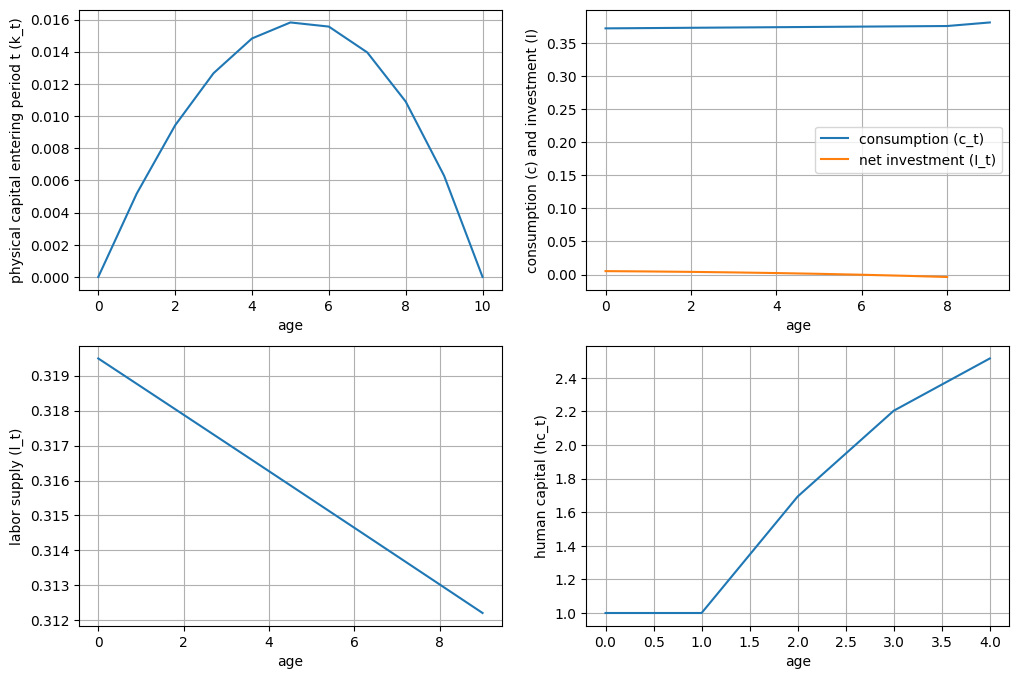

iter: 1; K change: 0.24; H change: 0.05; L change: 0.01; Z change: 0.11
y: 0.5377380198080052
ie: 0.03226428118848031
tax_revenue: 0.05656066799842038
grants: 0.03764166138656037
T: 0.02967376700802013
iter: 1; K: 0.53; H: 2.10; L: 0.30; Z: 0.11
iter: 1; Y: 0.54; tau: 0.15; T: 0.03

Full output of k1_optimal_array[0]:
[[0.01041274 0.00945521 0.00845059 0.00739762 0.00629508 0.00514181
  0.00393672 0.00267869 0.00136677 0.        ]
 [0.01041426 0.0094566  0.00845183 0.00739871 0.00629601 0.00514256
  0.00393729 0.00267909 0.00136697 0.        ]
 [0.0104214  0.00946307 0.00845762 0.00740377 0.00630032 0.00514608
  0.00393999 0.00268092 0.00136791 0.        ]
 [0.01043663 0.00947691 0.00846998 0.00741459 0.00630953 0.00515361
  0.00394575 0.00268484 0.00136991 0.        ]
 [0.01046185 0.0094998  0.00849045 0.00743251 0.00632477 0.00516606
  0.00395528 0.00269133 0.00137322 0.        ]
 [0.0104987  0.00953326 0.00852035 0.00745869 0.00634705 0.00518425
  0.00396921 0.00270081 0.00137806 0.

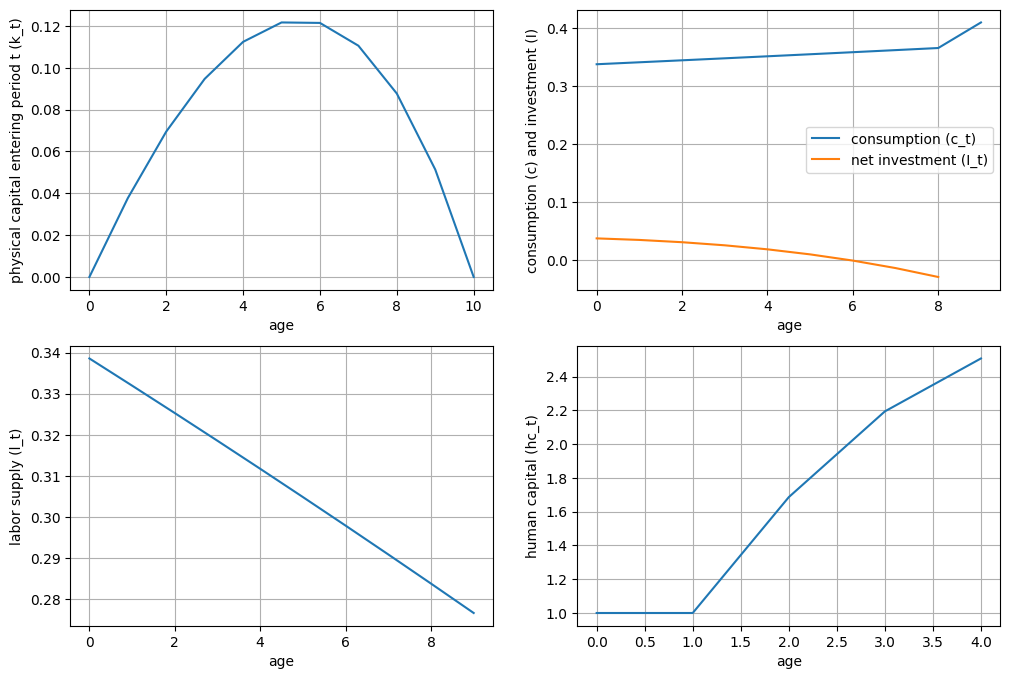

iter: 2; K change: 0.20; H change: 0.04; L change: 0.00; Z change: 0.09
y: 0.5326635481456397
ie: 0.03195981288873838
tax_revenue: 0.05729338369078611
grants: 0.03728644837019478
T: 0.030660206283504132
iter: 2; K: 0.44; H: 2.18; L: 0.30; Z: 0.12
iter: 2; Y: 0.53; tau: 0.15; T: 0.03

Full output of k1_optimal_array[0]:
[[0.01702886 0.01557745 0.01402586 0.01236969 0.0106046  0.00872625
  0.00673062 0.00461359 0.00237132 0.        ]
 [0.01703134 0.01557972 0.01402791 0.01237149 0.01060614 0.00872752
  0.0067316  0.00461427 0.00237167 0.        ]
 [0.01704291 0.0155903  0.01403743 0.01237989 0.01061334 0.00873344
  0.00673617 0.0046174  0.00237328 0.        ]
 [0.01706759 0.01561288 0.01405776 0.01239782 0.01062872 0.00874609
  0.00674593 0.00462409 0.00237672 0.        ]
 [0.01710847 0.01565028 0.01409143 0.01242752 0.01065418 0.00876704
  0.00676209 0.00463516 0.00238241 0.        ]
 [0.01716821 0.01570492 0.01414063 0.01247091 0.01069138 0.00879765
  0.0067857  0.00465135 0.00239073 0

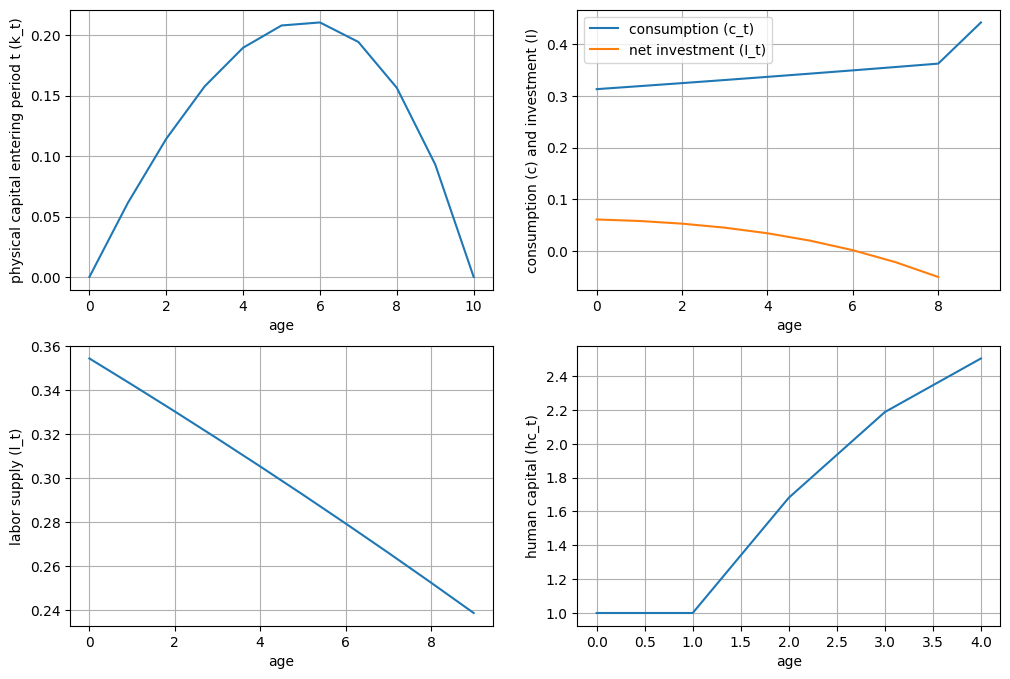

iter: 3; K change: 0.16; H change: 0.03; L change: 0.00; Z change: 0.07
y: 0.5265737800126682
ie: 0.03159442680076009
tax_revenue: 0.05745738486468469
grants: 0.03686016460088678
T: 0.031128695864051287
iter: 3; K: 0.38; H: 2.25; L: 0.30; Z: 0.13
iter: 3; Y: 0.53; tau: 0.15; T: 0.03

Full output of k1_optimal_array[0]:
[[0.02155844 0.01984456 0.01798107 0.01595897 0.01376945 0.01140329
  0.00885191 0.00610656 0.00315867 0.        ]
 [0.02156156 0.01984744 0.01798368 0.01596129 0.01377144 0.01140495
  0.0088532  0.00610744 0.00315912 0.        ]
 [0.02157611 0.01986083 0.01799581 0.01597206 0.01378073 0.01141265
  0.00885917 0.00611156 0.00316126 0.        ]
 [0.02160717 0.01988944 0.01802173 0.01599506 0.01380058 0.01142908
  0.00887193 0.00612036 0.00316581 0.        ]
 [0.02165861 0.01993682 0.01806465 0.01603315 0.01383345 0.0114563
  0.00889306 0.00613494 0.00317335 0.        ]
 [0.02173378 0.02000603 0.01812736 0.01608881 0.01388147 0.01149607
  0.00892393 0.00615624 0.00318436 0.

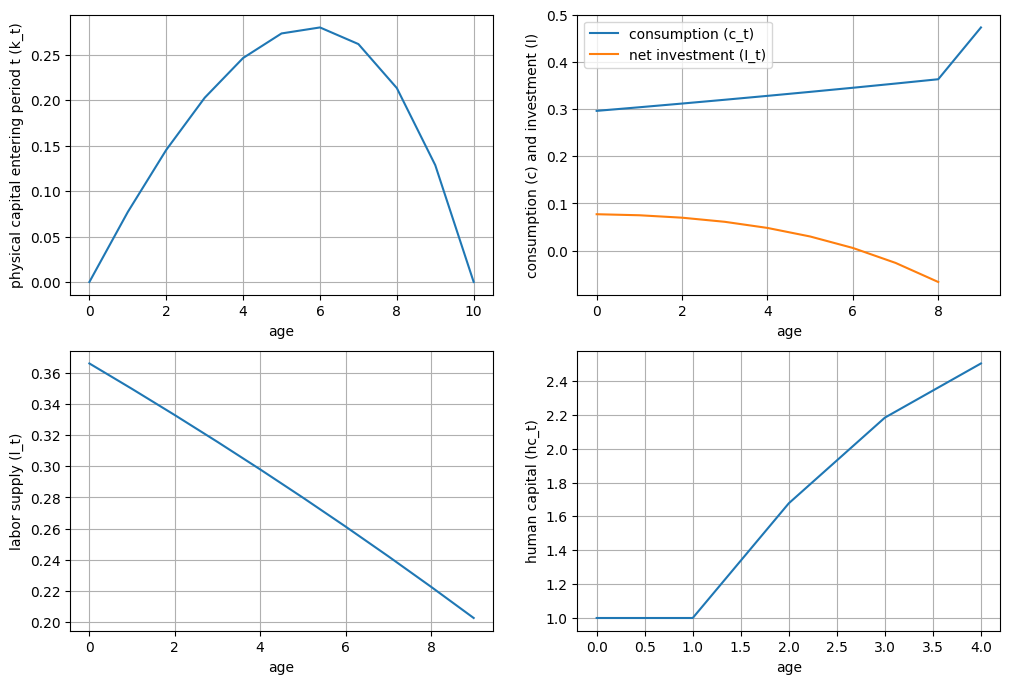

iter: 4; K change: 0.11; H change: 0.02; L change: 0.01; Z change: 0.06
y: 0.5206124744536276
ie: 0.03123674846721765
tax_revenue: 0.05732123393705734
grants: 0.036442873211753934
T: 0.031290610214375986
iter: 4; K: 0.34; H: 2.30; L: 0.30; Z: 0.14
iter: 4; Y: 0.52; tau: 0.15; T: 0.03

Full output of k1_optimal_array[0]:
[[0.02449253 0.02265458 0.02062606 0.0183966  0.01595135 0.01327619
  0.01035728 0.00718074 0.00373285 0.        ]
 [0.02449607 0.02265785 0.02062904 0.01839926 0.01595366 0.01327811
  0.01035878 0.00718178 0.00373339 0.        ]
 [0.02451255 0.02267308 0.02064292 0.01841163 0.01596439 0.01328704
  0.01036575 0.00718661 0.0037359  0.        ]
 [0.02454776 0.0227056  0.02067256 0.01843806 0.0159873  0.01330612
  0.01038062 0.00719693 0.00374126 0.        ]
 [0.02460606 0.02275946 0.02072164 0.01848182 0.01602525 0.0133377
  0.01040526 0.00721401 0.00375015 0.        ]
 [0.02469125 0.02283816 0.02079336 0.01854576 0.0160807  0.01338385
  0.01044126 0.00723897 0.00376312 0

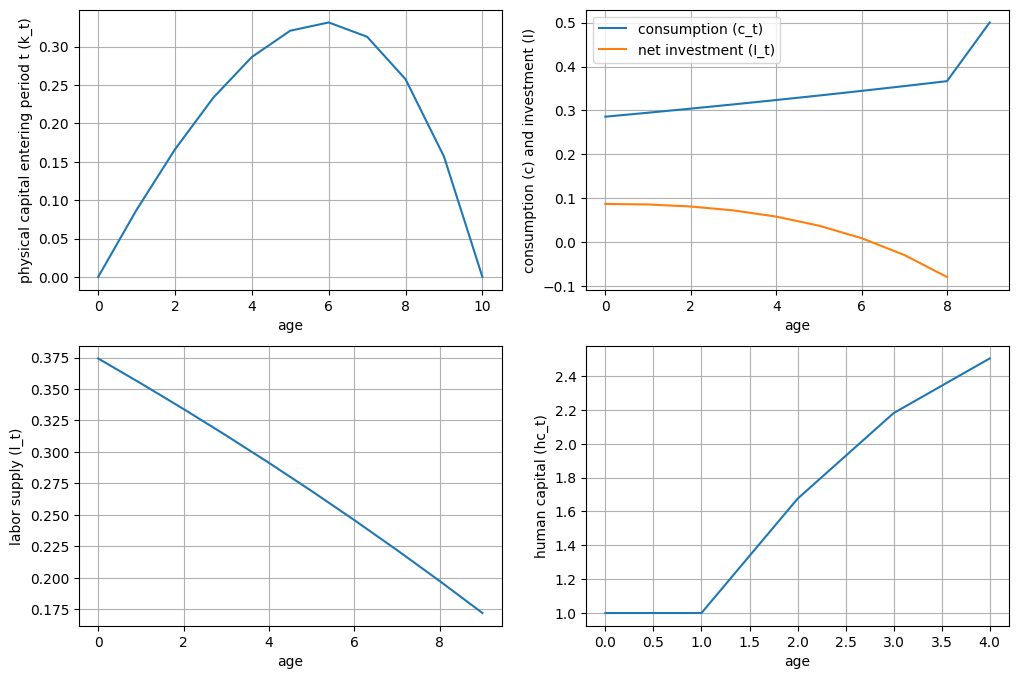

iter: 5; K change: 0.08; H change: 0.02; L change: 0.02; Z change: 0.05
y: 0.5153076566865279
ie: 0.030918459401191672
tax_revenue: 0.05704981348921668
grants: 0.036071535968056956
T: 0.03128443065489028
iter: 5; K: 0.32; H: 2.34; L: 0.30; Z: 0.15
iter: 5; Y: 0.52; tau: 0.15; T: 0.03

Full output of k1_optimal_array[0]:
[[0.02633256 0.02443569 0.02232495 0.01997925 0.01738427 0.01451955
  0.01136725 0.00790884 0.00412586 0.        ]
 [0.02633636 0.02443921 0.02232816 0.01998213 0.01738678 0.01452165
  0.01136889 0.00790998 0.00412645 0.        ]
 [0.0263541  0.0244556  0.02234317 0.01999555 0.01739845 0.0145314
  0.01137653 0.00791529 0.00412923 0.        ]
 [0.02639196 0.02449061 0.0223752  0.02002421 0.01742339 0.01455223
  0.01139284 0.00792664 0.00413514 0.        ]
 [0.02645466 0.02454859 0.02242824 0.02007167 0.01746468 0.01458672
  0.01141984 0.00794543 0.00414494 0.        ]
 [0.02654629 0.02463333 0.02250574 0.02014102 0.01752502 0.01463711
  0.01145929 0.00797288 0.00415926 0

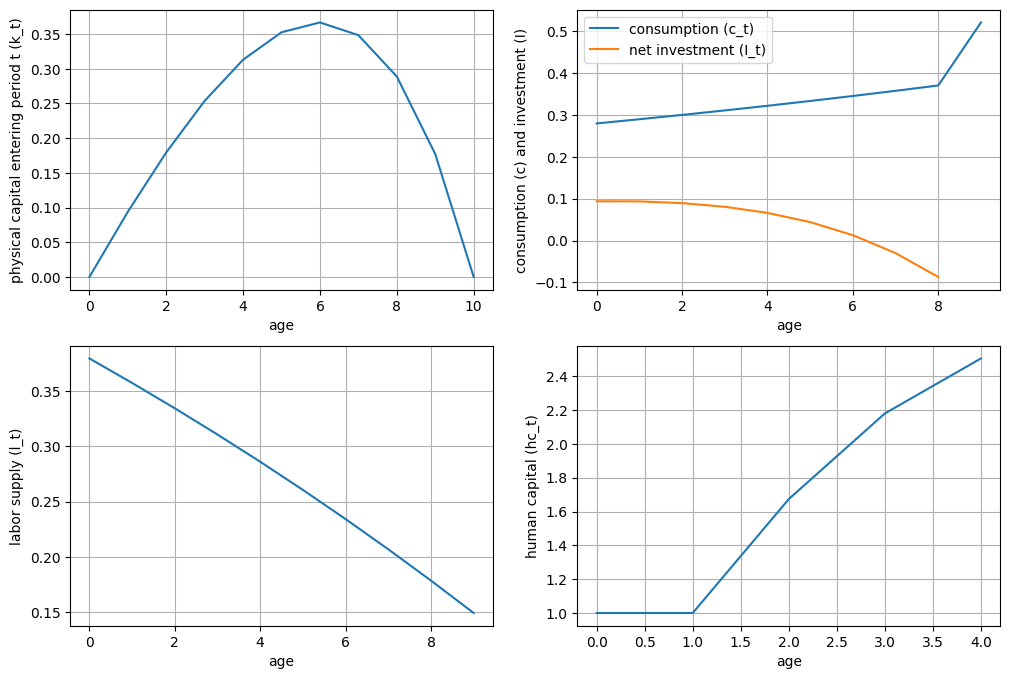

iter: 6; K change: 0.05; H change: 0.01; L change: 0.02; Z change: 0.04
y: 0.510835639156436
ie: 0.030650138349386163
tax_revenue: 0.05673842844170634
grants: 0.035758494740950525
T: 0.03119664648388454
iter: 6; K: 0.30; H: 2.37; L: 0.29; Z: 0.16
iter: 6; Y: 0.51; tau: 0.15; T: 0.03

Full output of k1_optimal_array[0]:
[[0.02747473 0.02554416 0.02339012 0.02097848 0.01829469 0.01531467
  0.01201718 0.00838024 0.00438177 0.        ]
 [0.0274787  0.02554784 0.02339349 0.0209815  0.01829732 0.01531688
  0.01201892 0.00838145 0.0043824  0.        ]
 [0.02749721 0.02556497 0.0234092  0.02099559 0.01830961 0.01532716
  0.01202699 0.00838707 0.00438534 0.        ]
 [0.02753673 0.02560155 0.02344275 0.02102568 0.01833584 0.01534913
  0.01204422 0.00839909 0.00439163 0.        ]
 [0.02760216 0.02566215 0.02349831 0.0210755  0.01837928 0.01538549
  0.01207276 0.00841899 0.00440203 0.        ]
 [0.02769772 0.02575074 0.02357947 0.02114831 0.01844276 0.01543863
  0.01211446 0.00844807 0.00441723 0

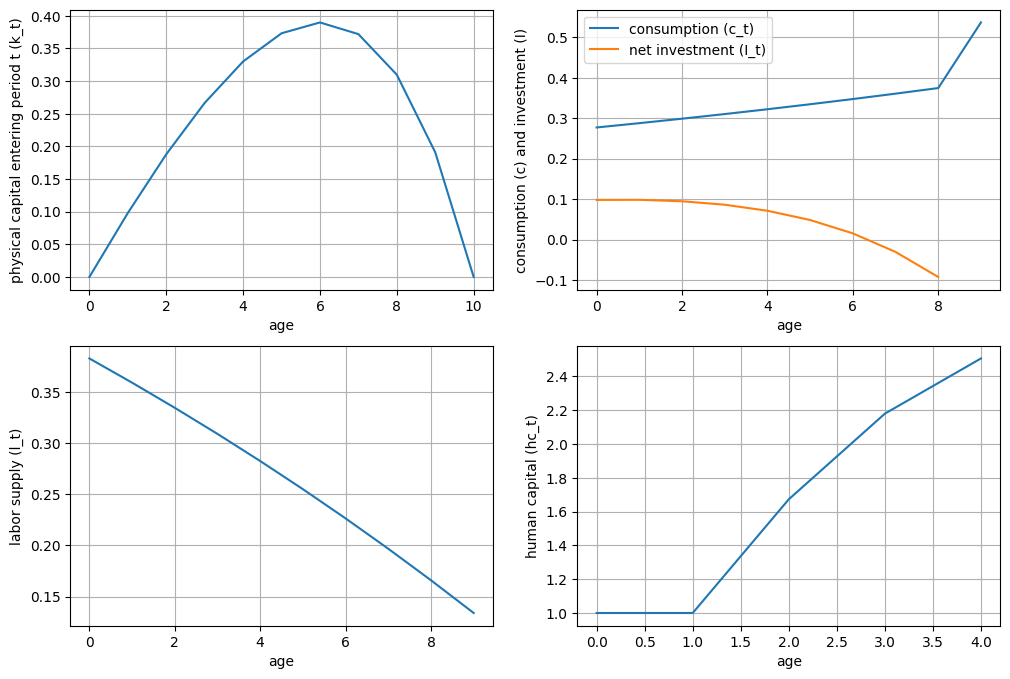

iter: 7; K change: 0.03; H change: 0.01; L change: 0.02; Z change: 0.04
y: 0.5072048903767558
ie: 0.030432293422605346
tax_revenue: 0.05643928366907866
grants: 0.03550434232637291
T: 0.031079039150240878
iter: 7; K: 0.30; H: 2.40; L: 0.29; Z: 0.16
iter: 7; Y: 0.51; tau: 0.15; T: 0.03

Full output of k1_optimal_array[0]:
[[0.02818221 0.02623232 0.02405111 0.02160045 0.01886225 0.01581144
  0.0124241  0.008676   0.00454267 0.        ]
 [0.02818629 0.0262361  0.02405458 0.02160357 0.01886497 0.01581372
  0.01242589 0.00867725 0.00454332 0.        ]
 [0.02820528 0.02625372 0.02407073 0.02161809 0.01887764 0.01582434
  0.01243424 0.00868308 0.00454638 0.        ]
 [0.02824581 0.02629135 0.02410522 0.02164908 0.0189047  0.01584702
  0.01245206 0.00869553 0.00455289 0.        ]
 [0.02831291 0.02635367 0.02416234 0.02170041 0.0189495  0.01588458
  0.01248158 0.00871614 0.00456368 0.        ]
 [0.02841087 0.02644478 0.02424579 0.02177542 0.01901496 0.01593946
  0.0125247  0.00874626 0.00457945 

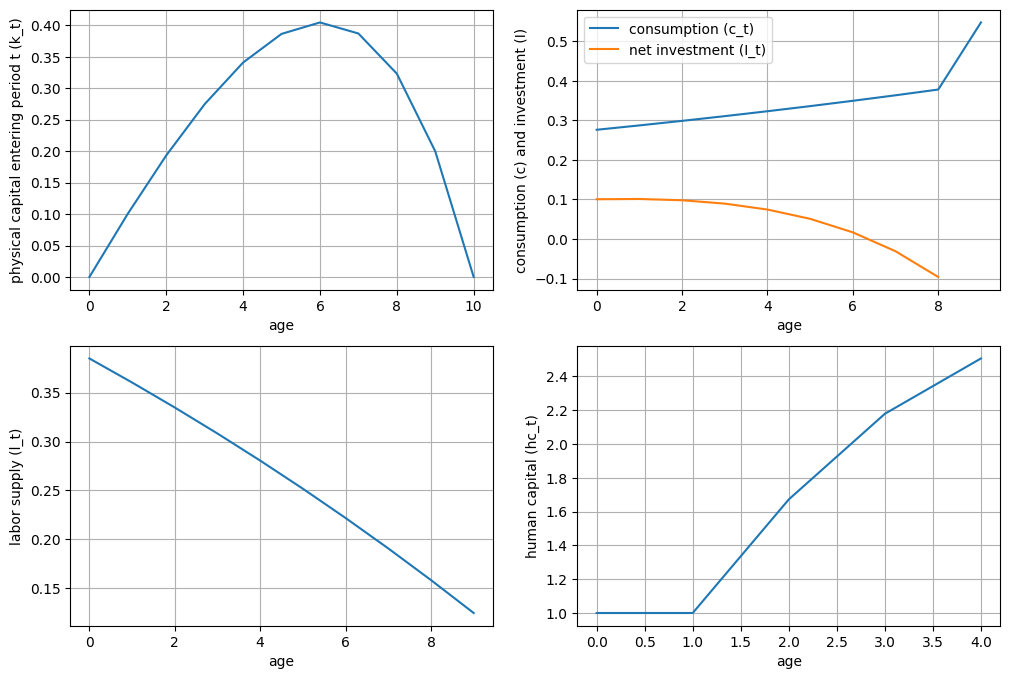

iter: 8; K change: 0.02; H change: 0.01; L change: 0.02; Z change: 0.03
y: 0.5043502704233501
ie: 0.030261016225401005
tax_revenue: 0.05617825722338897
grants: 0.035304518929634515
T: 0.030960743702221474
iter: 8; K: 0.29; H: 2.42; L: 0.28; Z: 0.17
iter: 8; Y: 0.50; tau: 0.15; T: 0.03

Full output of k1_optimal_array[0]:
[[0.02862434 0.02666228 0.02446218 0.02198662 0.01921382 0.01611861
  0.01267532 0.00885835 0.00464176 0.        ]
 [0.02862848 0.02666613 0.02446571 0.0219898  0.01921659 0.01612094
  0.01267715 0.00885963 0.00464243 0.        ]
 [0.02864776 0.02668408 0.02448214 0.02200459 0.0192295  0.01613177
  0.01268567 0.00886558 0.00464554 0.        ]
 [0.02868891 0.02672239 0.02451723 0.02203617 0.01925708 0.01615491
  0.01270387 0.0088783  0.00465221 0.        ]
 [0.02875701 0.02678586 0.02457533 0.02208846 0.01930275 0.01619323
  0.012734   0.00889936 0.00466324 0.        ]
 [0.02885643 0.02687865 0.02466023 0.02216487 0.01936948 0.01624922
  0.01277803 0.00893013 0.00467937

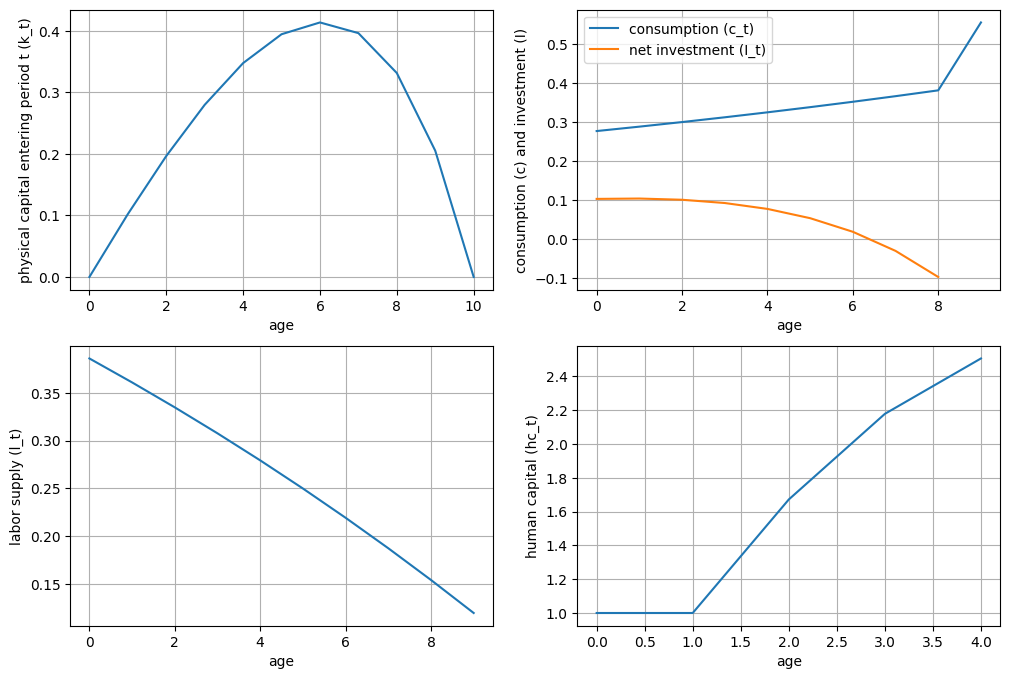

iter: 9; K change: 0.01; H change: 0.01; L change: 0.01; Z change: 0.03
y: 0.5021757137293442
ie: 0.030130542823760653
tax_revenue: 0.05596519898012563
grants: 0.035152299961054095
T: 0.030856413293658416
iter: 9; K: 0.29; H: 2.44; L: 0.28; Z: 0.17
iter: 9; Y: 0.50; tau: 0.15; T: 0.03

Full output of k1_optimal_array[0]:
[[0.02890624 0.02693524 0.02472115 0.02222856 0.01943281 0.01630898
  0.01283027 0.00897032 0.00470236 0.        ]
 [0.02891042 0.02693913 0.02472471 0.02223177 0.01943562 0.01631134
  0.01283212 0.00897162 0.00470304 0.        ]
 [0.02892987 0.02695729 0.02474133 0.02224673 0.01944869 0.01632231
  0.01284075 0.00897765 0.0047062  0.        ]
 [0.0289714  0.02699607 0.02477681 0.02227868 0.0194766  0.01634574
  0.01285919 0.00899054 0.00471295 0.        ]
 [0.02904012 0.0270603  0.02483555 0.0223316  0.01952282 0.01638454
  0.01288971 0.00901188 0.00472414 0.        ]
 [0.02914043 0.02715419 0.0249214  0.02240891 0.01959036 0.01644124
  0.01293431 0.00904306 0.00474049

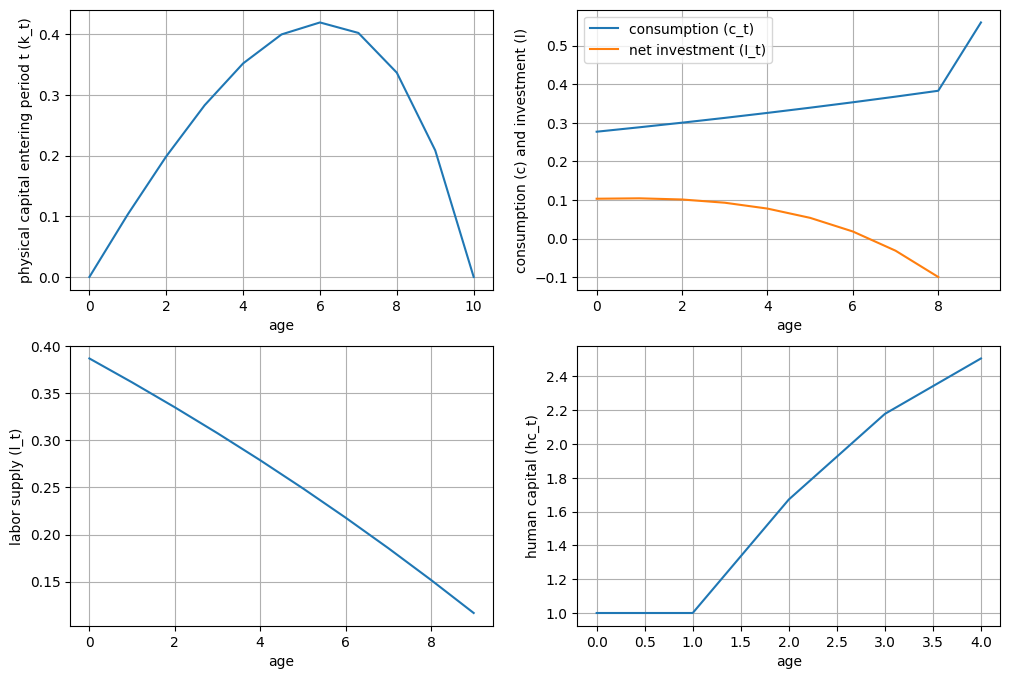

iter: 10; K change: 0.01; H change: 0.01; L change: 0.01; Z change: 0.02
y: 0.5005750771357463
ie: 0.03003450462814478
tax_revenue: 0.0558005996942189
grants: 0.03504025539950225
T: 0.030771845837431585
iter: 10; K: 0.28; H: 2.45; L: 0.27; Z: 0.18
iter: 10; Y: 0.50; tau: 0.15; T: 0.03

Full output of k1_optimal_array[0]:
[[0.02909142 0.02711316 0.02488828 0.02238335 0.01957175 0.0164288
  0.01292706 0.00903977 0.00473969 0.        ]
 [0.02909562 0.02711708 0.02489188 0.02238659 0.01957458 0.01643118
  0.01292892 0.00904108 0.00474037 0.        ]
 [0.02911518 0.02713539 0.02490861 0.02240167 0.01958776 0.01644224
  0.01293763 0.00904716 0.00474357 0.        ]
 [0.02915694 0.02717448 0.02494436 0.02243387 0.01961589 0.01646586
  0.01295621 0.00906016 0.00475038 0.        ]
 [0.02922605 0.02723922 0.02500354 0.02248719 0.01966248 0.01650498
  0.01298699 0.00908168 0.00476166 0.        ]
 [0.02932693 0.02733385 0.02509003 0.02256509 0.01973055 0.01656214
  0.01303196 0.00911313 0.00477815 

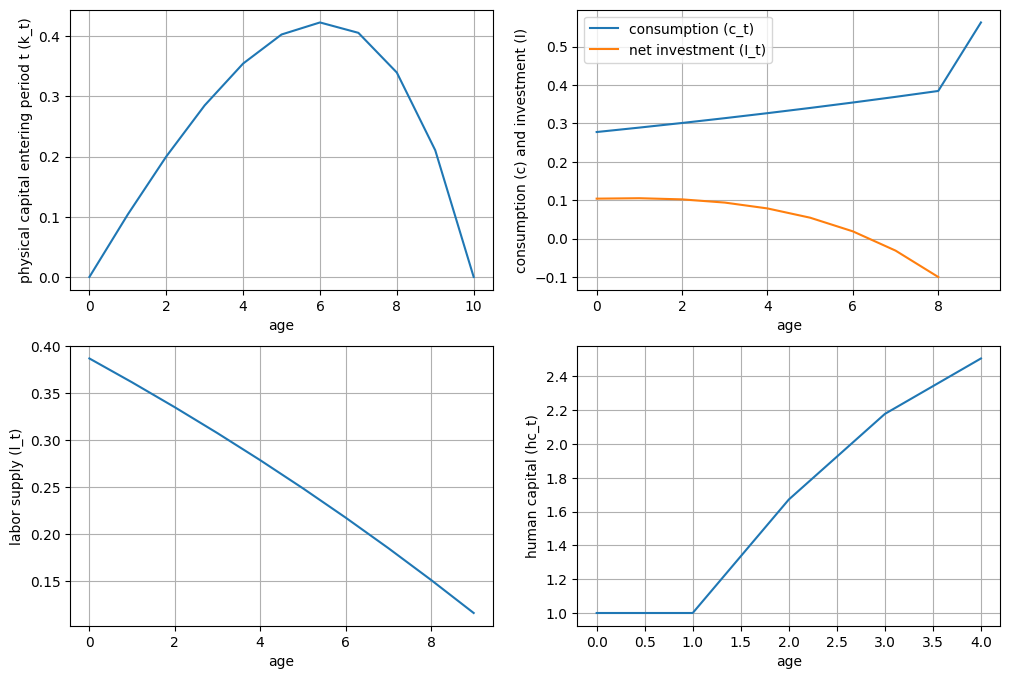

iter: 11; K change: 0.00; H change: 0.00; L change: 0.01; Z change: 0.02
y: 0.4994441150329171
ie: 0.029966646901975022
tax_revenue: 0.05568000987872829
grants: 0.0349610880523042
T: 0.030707804127082433
iter: 11; K: 0.28; H: 2.46; L: 0.27; Z: 0.18
iter: 11; Y: 0.50; tau: 0.15; T: 0.03

Full output of k1_optimal_array[0]:
[[0.02921784 0.0272335  0.02500006 0.02248577 0.01966273 0.01650647
  0.01298919 0.00908393 0.00476322 0.        ]
 [0.02922206 0.02723745 0.02500368 0.02248902 0.01966558 0.01650886
  0.01299106 0.00908524 0.00476391 0.        ]
 [0.02924169 0.02725585 0.0250205  0.02250418 0.01967882 0.01651998
  0.01299981 0.00909136 0.00476712 0.        ]
 [0.0292836  0.02729516 0.02505642 0.02253655 0.0197071  0.01654373
  0.0130185  0.00910443 0.00477397 0.        ]
 [0.02935297 0.02736025 0.02511592 0.02259014 0.01975394 0.01658306
  0.01304945 0.00912607 0.00478532 0.        ]
 [0.02945424 0.02745537 0.02520285 0.02266845 0.01982238 0.01664053
  0.01309467 0.0091577  0.0048019

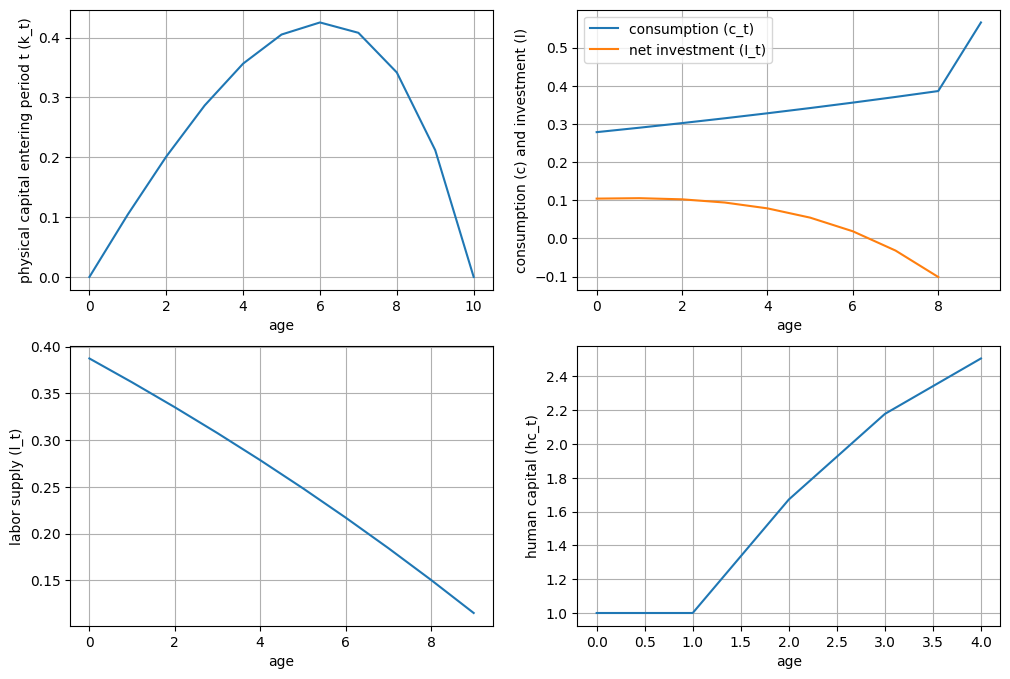

iter: 12; K change: 0.00; H change: 0.00; L change: 0.01; Z change: 0.02
y: 0.4986875112050933
ie: 0.029921250672305597
tax_revenue: 0.055596864900288076
grants: 0.034908125784356536
T: 0.03066248934003342
iter: 12; K: 0.28; H: 2.47; L: 0.27; Z: 0.18
iter: 12; Y: 0.50; tau: 0.15; T: 0.03

Full output of k1_optimal_array[0]:
[[0.02930815 0.02731864 0.02507827 0.02255661 0.01972496 0.01655901
  0.01303075 0.00911316 0.00477863 0.        ]
 [0.02931237 0.0273226  0.0250819  0.02255987 0.01972782 0.01656141
  0.01303264 0.00911448 0.00477932 0.        ]
 [0.02933206 0.02734108 0.02509878 0.02257509 0.01974111 0.01657257
  0.01304142 0.00912062 0.00478254 0.        ]
 [0.02937408 0.02738054 0.02513484 0.02260757 0.0197695  0.01659641
  0.01306018 0.00913374 0.00478942 0.        ]
 [0.02944363 0.02744588 0.02519456 0.02266136 0.01981651 0.01663589
  0.01309124 0.00915546 0.00480081 0.        ]
 [0.02954516 0.02754135 0.02528182 0.02273995 0.01988521 0.01669357
  0.01313663 0.0091872  0.00481

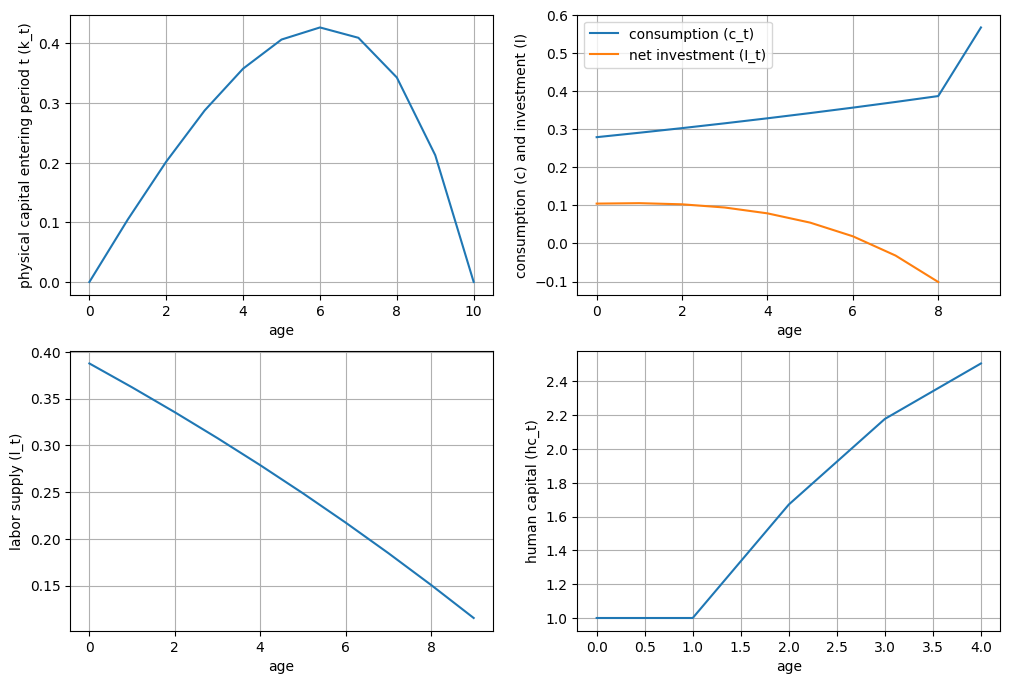

iter: 13; K change: 0.00; H change: 0.00; L change: 0.01; Z change: 0.01
y: 0.49822237080805903
ie: 0.029893342248483543
tax_revenue: 0.05554416067495134
grants: 0.03487556595656414
T: 0.0306330421345484
iter: 13; K: 0.28; H: 2.48; L: 0.27; Z: 0.19
iter: 13; Y: 0.50; tau: 0.15; T: 0.03

Full output of k1_optimal_array[0]:
[[0.0293758  0.02738189 0.0251358  0.02260816 0.01976979 0.01659645
  0.01306005 0.00913354 0.00478925 0.        ]
 [0.02938004 0.02738587 0.02513944 0.02261144 0.01977265 0.01659885
  0.01306194 0.00913486 0.00478995 0.        ]
 [0.02939976 0.0274044  0.02515637 0.02262669 0.01978598 0.01661005
  0.01307075 0.00914102 0.00479318 0.        ]
 [0.02944186 0.02744397 0.02519253 0.02265926 0.01981445 0.01663395
  0.01308956 0.00915417 0.00480007 0.        ]
 [0.02951154 0.02750948 0.02525242 0.02271319 0.01986159 0.01667353
  0.0131207  0.00917595 0.0048115  0.        ]
 [0.02961326 0.02760522 0.02533994 0.02279199 0.01993047 0.01673137
  0.01316622 0.00920778 0.0048281

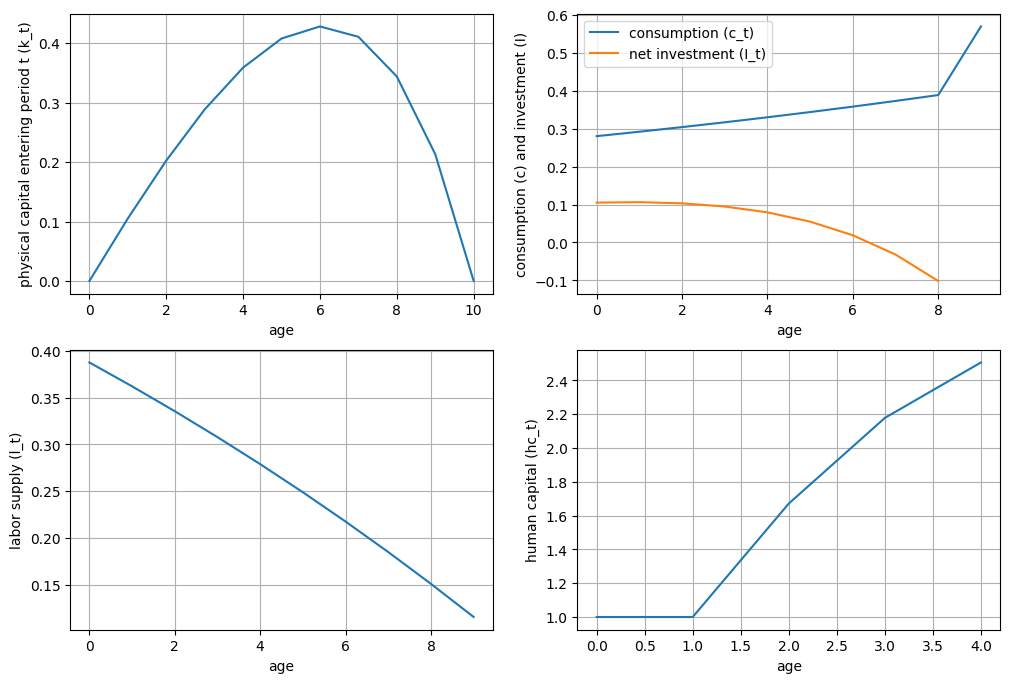

In [14]:
hc_min = np.ones(child_periods+1)
hc_max = np.ones(child_periods+1)
e_mean = 0.02 * np.ones(child_periods+1)
e_minprop = 0.001
e_maxprop = 1
deggridh = 2.5
deggridk = 3.0

hc_grid = np.zeros((nh, child_periods + 1))


iteration = -1
K_diff = 1 + tolerance
state_var_iter_array = np.zeros((max_iters,4))

omega = 0.1


v_optimal_array = np.zeros((na, nh, periods + 1)) #vw initialize the agents' value function array
k1_optimal_array = np.zeros((na, nh, periods)) #initialize the optimal capital array
c_optimal_array = np.zeros((na, nh, periods)) #initialize the optimal consumption array
l_optimal_array = np.zeros((na, nh, periods)) #initialize the optimal labor array
h_optimal_array = np.zeros((na, nh, periods)) #initialize the optimal child human capital array
hc_optimal_array = np.zeros((na, nh, child_periods)) #initialize the optimal child human capital array


v3d_optimal_array = np.zeros((na, nh, periods + 1, nh))

max_iters_ss = max_iters
# tolerance_ss = 0.01

#loop while max_iters not exceeded and difference between this K guess and previous K guess is greater than acceptable tolerance
while iteration < max_iters - 1 and K_diff > tolerance: #TODO fix k tolerance
  iteration += 1
  K_diff = abs((K_bar - K_old) / K_bar)
  H_diff = abs((H_bar - H_old) / H_bar) #can you solve for H in terms of K?
  L_diff = abs((L_bar - L_old) / L_bar)
  Z_diff = abs((Z_bar - Z_old) / Z_bar)
  print(f"iter: {iteration}; K change: {K_diff:.2f}; H change: {H_diff:.2f}; L change: {L_diff:.2f}; Z change: {Z_diff:.2f}")

  #calculate variables based on new guess of K, H, L
  w = wage_rate(Z_prev = Z_bar, K_prev = K_bar, H = H_bar, L = L_bar)
  r = interest_rate(Z_prev = Z_bar, K_prev = K_bar, H = H_bar, L = L_bar)
  Y = production(Z_prev = Z_bar, K_prev = K_bar, H = H_bar, L = L_bar)
  grants = G_gdp * Y
  Iz = Iz_gdp * Y
  Ie = Ie_gdp * Y
  I_e_mean = (0.03*Y)

  print(f"y: {Y}")
  print(f"ie: {Ie}")

  tax_revenue = tau*w*H_bar*L_bar + tau*r*K_bar
  print(f"tax_revenue: {tax_revenue}")
  print(f"grants: {grants}")
  T = transfer(K_prev = K_bar, H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r) - Iz - Ie


  #SHOULD THIS BE HERE OR END?
  print(f"T: {T}")
  print(f"iter: {iteration}; K: {K_bar:.2f}; H: {H_bar:.2f}; L: {L_bar:.2f}; Z: {Z_bar:.2f}")
  print(f"iter: {iteration}; Y: {Y:.2f}; tau: {tau:.2f}; T: {T:.2f}")
  K_old = K_bar
  H_old = H_bar
  L_old = L_bar
  Z_old = Z_bar
  state_var_iter_array[iteration, 0] = K_old #TODO: update these each iteration
  state_var_iter_array[iteration, 1] = H_old
  state_var_iter_array[iteration, 2] = L_old
  state_var_iter_array[iteration, 3] = Z_old






  #FIRST ITER ONLY
  if iteration == 0:
    #minimun hc vectors
    for i in range(1, child_periods + 1): 
      hc_min[i] = human_capital_formation(h_c = hc_min[i-1], e_p = e_mean[i]*e_minprop, I_e = Ie, e_mean = e_mean[i], I_e_mean = I_e_mean)

      hc_min[i] = human_capital_formation(h_c = hc_min[i-1], e_p = e_mean[i]*e_minprop, I_e = Ie, e_mean = e_mean[i], I_e_mean = I_e_mean)

    #maximun hc vectors
    for i in range(1, child_periods + 1):
      hc_max[i] = human_capital_formation(h_c = hc_max[i-1], e_p = e_mean[i]*e_maxprop, I_e = Ie, e_mean = e_mean[i], I_e_mean = I_e_mean)



    # print("hc_min:", hc_min)
    # print("hc_max:", hc_max)

    # hc_minval = min(hc_min[1:])
    # hc_maxval = max(hc_max[1:])


    #see 402-404 #UNCOMMENT LATER
    # dampssbfinal = speedbeta
    # dampssw1final = dampssw
    # dampssw2final = dampssw

  # h_grid = loggrid(hc_minval[child_periods-1], min(h_max, hc_maxval[child_periods-1]), nh, deggridh)
  # h_grid = loggrid(hc_min[child_periods], min(h_max, hc_max[child_periods]), nh, deggridh)
  h_grid = loggrid(hc_min[child_periods], max(h_max, hc_max[child_periods]), nh, deggridh)

    # print(f"h_grid: {h_grid}")
  k_grid = loggrid(k_min, k_max, na, deggridk)
    # print(f"h_grid: {k_grid}")


  for i in range(child_periods + 1):
      hc_grid[:,i] = loggrid(hc_min[i], hc_max[i], nh, deggridh)
      # print(f"period {i}")
      # print(hc_grid[:,i])


  invTa = spbas(na - 2, k_grid)
    # print(invTa)

  invTh = spbas(nh - 2, h_grid)

  for i in range(child_periods):
      invThcall = np.ones((nh - 2, nh -2, child_periods))
      z = spbas(nh - 2, hc_grid[:,i])
      # print(z)
      invThcall[:,:,i] = z

  # print(invTa)
  # print(invThcall[:,:,2])
    # break #427
    # compute last period value function st eq. 15 
    # FIX THIS LATER

  #last period
  for ik in range(na):
    for ih in range(nh):
      l_optimal_array[ik, ih, periods - 1] = labor_foc(k = 0, k_prev = k_grid[ik], h = h_grid[ih], w = w, r = r, tau = tau, T = T) 
      final_period_assets = (1-tau)*w*h_grid[ih]*l_optimal_array[ik, ih, periods - 1] + (1+r)*k_grid[ik] - tau*r*max(k_grid[ik], 0) + T
      v_optimal_array[ik, ih, periods - 1] = utility(final_period_assets, l_optimal_array[ik, ih, periods - 1])
      c_optimal_array[ik, ih, periods - 1] = final_period_assets
      # h_optimal_array[ik, ih, periods - 1] = h
      k1_optimal_array[ik, ih, periods - 1] = 0

    #looking at j = 8
  # for ik in range(na):
  #   for ih in range(nh):

    



  # print(f"T: {T}")
  # print(f"iter: {iteration}; K: {K_bar:.2f}; H: {H_bar:.2f}; L: {L_bar:.2f}; Z: {Z_bar:.2f}")
  # print(f"iter: {iteration}; Y: {Y:.2f}; tau: {tau:.2f}; T: {T:.2f}")
  # K_old = K_bar
  # H_old = H_bar
  # L_old = L_bar
  # Z_old = Z_bar
  # state_var_iter_array[iteration, 0] = K_old #TODO: update these each iteration
  # state_var_iter_array[iteration, 1] = H_old
  # state_var_iter_array[iteration, 2] = L_old
  # state_var_iter_array[iteration, 3] = Z_old


  


  # #compute last period value function st eq. 15
  # for i in range(na):
  #   l_optimal_array[i, periods - 1] = labor_foc(k = 0, k_prev = k_grid[i], h = h, w = w, r = r, tau = tau, T = T) #ADDednfoc
  #   final_period_assets = (1-tau)*w*h*l_optimal_array[i, periods - 1] + (1+r)*k_grid[i] - tau*r*max(k_grid[i], 0) + T
  #   value_array[i, periods - 1] = utility(final_period_assets, l_optimal_array[i, periods - 1])
  #   c_optimal_array[i, periods - 1] = final_period_assets
  #   h_optimal_array[i, periods - 1] = h
  #   k_optimal_array[i, periods - 1] = 0
  #second to last to 
  for i in range(periods-1, child_periods, -1): #loop backwards from age 60 to 0
    for ih in range(nh):
      vr_polate = interpolate.interp1d(k_grid, v_optimal_array[:,ih,i], kind='cubic', fill_value='extrapolate') #interpolator which lines up k_grid with value_array row i
      h0 = h_grid[ih]
      m0 = 0

      for ik in range(na): #iteration through all possible kt-1 assets could come into periods with
        # print(f"backwards iter: {iteration}, solving for age: {i}, k_t-1: {k_grid[ik]}, h_t: {h_grid[ih]}")

        k0 = k_grid[ik]

        ax = 0
        bx = -1
        cx = -2
        v0 = neg
        m = max(-1, m0-2)

        while (ax > bx or bx > cx):
          m += 1
          v1 = value_function(vr_polate, k = k_grid[m], k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T)

          if v1 > v0:
            if m == 0:
              ax = k_grid[m]
              bx = k_grid[m]

            else:
              bx = k_grid[m]
              ax = k_grid[m-1]

            v0 = v1
            m0 = m

          else:
            cx = k_grid[m]

          if m==na-1:
            ax = k_grid[m-1]
            bx = k_grid[m] 
            cx = k_grid[m] 
          

        if ax==bx:  # corner solution: a'=0?
            # w = wage_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
            # r = interest_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
            # T = transfer(K_prev = k_grid[m], H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r)
            if value_function(vr_polate, k = ax, k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T) > value_function(vr_polate, k = k_eps, k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T):
              k1_optimal_array[ik, ih, i-1]=0
            else:
              # k_optimal_array[j,i-1] = Search(value_function, left=ax, initial_guess=k_eps, right=cx, tolerance=tolerance_gs, k_prev=k0, l=l, h=h, w=w, r=r, tau=tau, T=T)
              k1_optimal_array[ik, ih, i-1] = Search(vr_polate, value_function, ax, k_eps, cx, tolerance_gs,
                  k_prev=k0, h=h0, w=w, r=r, tau=tau, T=T).find_max()
                  
        elif bx==cx:  # corner solution: a'=a[na-1]=kmax?
            # w = wage_rate(K_prev = k_grid[na-1], H = H_bar, L = L_bar)
            # r = interest_rate(K_prev = k_grid[na-1], H = H_bar, L = L_bar)
            # T = transfer(K_prev = k_grid[na-1], H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r)
            if value_function(vr_polate, k = k_grid[na-1], k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T) > value_function(vr_polate, k = k_grid[na-1] - k_eps, k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T):
              k1_optimal_array[ik, ih, i-1] = k_grid[na-1]
            else:
              # k_optimal_array[j,i-1] = Search(value_function, left=k_grid[na-2], initial_guess=k_max-k_eps, right=k_max, tolerance=tolerance_gs,
              #     k_prev=k0, l=l, h=h, w=w, r=r, tau=tau, T=T)  
              k1_optimal_array[ik, ih, i-1] = Search(vr_polate, value_function, k_grid[na-2], k_max-k_eps, k_max, tolerance_gs,
                  k_prev=k0, h=h0, w=w, r=r, tau=tau, T=T).find_max()     
          
        else:
            # w = wage_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
            # r = interest_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
            # T = transfer(K_prev = k_grid[m], H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r)
            # k_optimal_array[j,i-1] = Search(value_function, left=ax, initial_guess=bx, right=cx, tolerance=tolerance_gs,
            #       k_prev=k0, l=l, h=h, w=w, r=r, tau=tau, T=T)
            k1_optimal_array[ik,ih, i-1] = Search(vr_polate, value_function, ax, bx, cx, tolerance_gs,
                  k_prev=k0, h=h0, w=w, r=r, tau=tau, T=T).find_max()
            
              

        k1 = k1_optimal_array[ik, ih, i-1]
        v_optimal_array[ik, ih, i-1] = value_function(vr_polate, k1_optimal_array[ik, ih, i-1], k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T)
      # l_optimal_array[ik, ih, i-1] = labor_foc(k = k1, k_prev = k0, h = h, w = w, r = r, tau = tau, T = T)
      # c_optimal_array[ik,ih, i-1] = (1-tau)*w*h*l_optimal_array[ik, ih, i-1] + r*k0 - tau*r*max(k0, 0) + T - k1
      # # print(f"iter: {iteration}, i: {i}, k opt: {k1}")

  #compute policy function for period 4 adult
  for i in range(child_periods, child_periods-1, -1): #loop backwards from age 60 to 0
    for ihc in range(nh):
      for ih in range(nh):
        vr_polate4 = interpolate.interp1d(k_grid, v3d_optimal_array[:,ih,i,ihc], kind='cubic', fill_value='extrapolate') #interpolator which lines up k_grid with value_array row i
        h0 = h_grid[ih]
        hc = h_grid[ihc]
        m0 = 0

        for ik in range(na): #iteration through all possible kt-1 assets could come into periods with
          # print(f"backwards iter: {iteration}, solving for age: {i}, k_t-1: {k_grid[ik]}, h_t: {h_grid[ih]}")

          k0 = k_grid[ik]

          ax = 0
          bx = -1
          cx = -2
          v0 = neg
          m = max(-1, m0-2)

          while (ax > bx or bx > cx):
            m += 1
            v1 = value_function(vr_polate, k = k_grid[m], k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T)

            if v1 > v0:
              if m == 0:
                ax = k_grid[m]
                bx = k_grid[m]

              else:
                bx = k_grid[m]
                ax = k_grid[m-1]

              v0 = v1
              m0 = m

            else:
              cx = k_grid[m]

            if m==na-1:
              ax = k_grid[m-1]
              bx = k_grid[m] 
              cx = k_grid[m] 
            

          if ax==bx:  # corner solution: a'=0?
              # w = wage_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
              # r = interest_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
              # T = transfer(K_prev = k_grid[m], H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r)
              if value_function(vr_polate, k = ax, k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T) > value_function(vr_polate, k = k_eps, k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T):
                k1_optimal_array[ik, ih, i-1]=0
              else:
                # k_optimal_array[j,i-1] = Search(value_function, left=ax, initial_guess=k_eps, right=cx, tolerance=tolerance_gs, k_prev=k0, l=l, h=h, w=w, r=r, tau=tau, T=T)
                k1_optimal_array[ik, ih, i-1] = Search(vr_polate, value_function, ax, k_eps, cx, tolerance_gs,
                    k_prev=k0, h=h0, w=w, r=r, tau=tau, T=T).find_max()
                    
          elif bx==cx:  # corner solution: a'=a[na-1]=kmax?
              # w = wage_rate(K_prev = k_grid[na-1], H = H_bar, L = L_bar)
              # r = interest_rate(K_prev = k_grid[na-1], H = H_bar, L = L_bar)
              # T = transfer(K_prev = k_grid[na-1], H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r)
              if value_function(vr_polate, k = k_grid[na-1], k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T) > value_function(vr_polate, k = k_grid[na-1] - k_eps, k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T):
                k1_optimal_array[ik, ih, i-1] = k_grid[na-1]
              else:
                # k_optimal_array[j,i-1] = Search(value_function, left=k_grid[na-2], initial_guess=k_max-k_eps, right=k_max, tolerance=tolerance_gs,
                #     k_prev=k0, l=l, h=h, w=w, r=r, tau=tau, T=T)  
                k1_optimal_array[ik, ih, i-1] = Search(vr_polate, value_function, k_grid[na-2], k_max-k_eps, k_max, tolerance_gs,
                    k_prev=k0, h=h0, w=w, r=r, tau=tau, T=T).find_max()     
            
          else:
              # w = wage_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
              # r = interest_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
              # T = transfer(K_prev = k_grid[m], H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r)
              # k_optimal_array[j,i-1] = Search(value_function, left=ax, initial_guess=bx, right=cx, tolerance=tolerance_gs,
              #       k_prev=k0, l=l, h=h, w=w, r=r, tau=tau, T=T)
              k1_optimal_array[ik,ih, i-1] = Search(vr_polate, value_function, ax, bx, cx, tolerance_gs,
                    k_prev=k0, h=h0, w=w, r=r, tau=tau, T=T).find_max()
              
                

          k1 = k1_optimal_array[ik, ih, i-1]
          v_optimal_array[ik, ih, i-1] = value_function(vr_polate, k1_optimal_array[ik, ih, i-1], k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T)
        # l_optimal_array[ik, ih, i-1] = labor_foc(k = k1, k_prev = k0, h = h, w = w, r = r, tau = tau, T = T)
        # c_optimal_array[ik,ih, i-1] = (1-tau)*w*h*l_optimal_array[ik, ih, i-1] + r*k0 - tau*r*max(k0, 0) + T - k1
        # # print(f"iter: {iteration}, i: {i}, k opt: {k1}")



  #compute policy function
  for i in range(child_periods-1, 0, -1): #loop backwards from age 60 to 0
    for ihc in range(nh):
      for ih in range(nh):
        vr_polate = interpolate.interp1d(k_grid, v_optimal_array[:,ih,i], kind='cubic', fill_value='extrapolate') #interpolator which lines up k_grid with value_array row i
        h0 = h_grid[ih]
        hc = h_grid[ihc]
        m0 = 0

        for ik in range(na): #iteration through all possible kt-1 assets could come into periods with
          # print(f"backwards iter: {iteration}, solving for age: {i}, k_t-1: {k_grid[ik]}, h_t: {h_grid[ih]}")

          k0 = k_grid[ik]

          ax = 0
          bx = -1
          cx = -2
          v0 = neg
          m = max(-1, m0-2)

          while (ax > bx or bx > cx):
            m += 1
            v1 = value_function(vr_polate, k = k_grid[m], k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T)

            if v1 > v0:
              if m == 0:
                ax = k_grid[m]
                bx = k_grid[m]

              else:
                bx = k_grid[m]
                ax = k_grid[m-1]

              v0 = v1
              m0 = m

            else:
              cx = k_grid[m]

            if m==na-1:
              ax = k_grid[m-1]
              bx = k_grid[m] 
              cx = k_grid[m] 
            

          if ax==bx:  # corner solution: a'=0?
              # w = wage_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
              # r = interest_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
              # T = transfer(K_prev = k_grid[m], H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r)
              if value_function(vr_polate, k = ax, k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T) > value_function(vr_polate, k = k_eps, k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T):
                k1_optimal_array[ik, ih, i-1]=0
              else:
                # k_optimal_array[j,i-1] = Search(value_function, left=ax, initial_guess=k_eps, right=cx, tolerance=tolerance_gs, k_prev=k0, l=l, h=h, w=w, r=r, tau=tau, T=T)
                k1_optimal_array[ik, ih, i-1] = Search(vr_polate, value_function, ax, k_eps, cx, tolerance_gs,
                    k_prev=k0, h=h0, w=w, r=r, tau=tau, T=T).find_max()
                    
          elif bx==cx:  # corner solution: a'=a[na-1]=kmax?
              # w = wage_rate(K_prev = k_grid[na-1], H = H_bar, L = L_bar)
              # r = interest_rate(K_prev = k_grid[na-1], H = H_bar, L = L_bar)
              # T = transfer(K_prev = k_grid[na-1], H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r)
              if value_function(vr_polate, k = k_grid[na-1], k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T) > value_function(vr_polate, k = k_grid[na-1] - k_eps, k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T):
                k1_optimal_array[ik, ih, i-1] = k_grid[na-1]
              else:
                # k_optimal_array[j,i-1] = Search(value_function, left=k_grid[na-2], initial_guess=k_max-k_eps, right=k_max, tolerance=tolerance_gs,
                #     k_prev=k0, l=l, h=h, w=w, r=r, tau=tau, T=T)  
                k1_optimal_array[ik, ih, i-1] = Search(vr_polate, value_function, k_grid[na-2], k_max-k_eps, k_max, tolerance_gs,
                    k_prev=k0, h=h0, w=w, r=r, tau=tau, T=T).find_max()     
            
          else:
              # w = wage_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
              # r = interest_rate(K_prev = k_grid[m], H = H_bar, L = L_bar)
              # T = transfer(K_prev = k_grid[m], H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r)
              # k_optimal_array[j,i-1] = Search(value_function, left=ax, initial_guess=bx, right=cx, tolerance=tolerance_gs,
              #       k_prev=k0, l=l, h=h, w=w, r=r, tau=tau, T=T)
              k1_optimal_array[ik,ih, i-1] = Search(vr_polate, value_function, ax, bx, cx, tolerance_gs,
                    k_prev=k0, h=h0, w=w, r=r, tau=tau, T=T).find_max()
              
                

          k1 = k1_optimal_array[ik, ih, i-1]
          v_optimal_array[ik, ih, i-1] = value_function(vr_polate, k1_optimal_array[ik, ih, i-1], k_prev = k0, h = h0, w = w, r = r, tau = tau, T = T)
        # l_optimal_array[ik, ih, i-1] = labor_foc(k = k1, k_prev = k0, h = h, w = w, r = r, tau = tau, T = T)
        # c_optimal_array[ik,ih, i-1] = (1-tau)*w*h*l_optimal_array[ik, ih, i-1] + r*k0 - tau*r*max(k0, 0) + T - k1
        # # print(f"iter: {iteration}, i: {i}, k opt: {k1}")



  
  # Display the full arrays without truncation
  np.set_printoptions(threshold=np.inf)
  print("\nFull output of k1_optimal_array[0]:")
  print(k1_optimal_array[0])
  print("\nFull output of k1_optimal_array[10]:")
  print(k1_optimal_array[10])
  # Reset print options to default
  np.set_printoptions(threshold=1000)

  iteration_ss = -1
  diff_ss = 99
  h0sim = 1
  max_iters_ss = 30
  hp = h0sim
  tolerance_ss = 0.005
  hc1 = 1

  # k_gen = np.zeros(periods + 1)
  # l_gen = np.zeros(periods)
  # c_gen = np.zeros(periods)
  # hc_gen = np.zeros(child_periods + 1)
  # i_gen = np.zeros(periods)

  while iteration_ss < max_iters_ss - 1 and diff_ss > tolerance_ss:
    iteration_ss += 1
    
    k_gen = np.zeros(periods + 1)
    l_gen = np.zeros(periods)
    c_gen = np.zeros(periods)
    hc_gen = np.zeros(child_periods + 1)
    i_gen = np.zeros(periods)


    k_gen[0] = k_start
    hc_gen[0] = hc1

    for q in range(periods):
      bi_polate = interpolate.RegularGridInterpolator((k_grid, h_grid), k1_optimal_array[:,:,q], method='linear', bounds_error=False, fill_value=None) #bilinear interpolator using k_grid and h_grid

      if q < periods - 1:
        k_gen[q+1] = float(bi_polate(np.array([[k_gen[q], hp]]))) #right index?
      else:
        k_gen[q+1] =0
      
      
      l_gen[q] = labor_foc(k = k_gen[q+1], k_prev = k_gen[q], h = hp, w = w, r = r, tau = tau, T = T)
      c_gen[q] = consumption(k_prev=k_gen[q], k=k_gen[q+1], h=hp, l=l_gen[q], w=w, r=r, tau=tau, T=T)
      i_gen[q] = -c_gen[q] + (1-tau)*w*hp*l_gen[q] + (r+delta)*k_gen[q] - tau*(r+delta)*max(k_gen[q], 0) + T


      #child concieved period 0 and born period 1
      if q == 0:
        hc_gen[1] = hc_gen[0]

      if q < child_periods and q > 0:
        #could have phi and everything vary here

        log_h = np.log(hp) + 1
        e_p = ((omega * log_h) * (1-l_gen[q])) / (1 + omega * log_h)
        hc_gen[q+1] = human_capital_formation(h_c = hc_gen[q], e_p = e_p, I_e = Ie, e_mean = e_mean[q], I_e_mean = I_e_mean)
        print(f"age: {q}, ep: {e_p}, hc: {hc_gen[q+1]}")

    print(f"Ie: {Ie}")
    final_period_assets = (1-tau)*w*hp*l_gen[periods-1] + (1+r)*k_gen[periods-2] - tau*r*max(k_gen[periods-2], 0) + T
    c_gen[periods-1] = final_period_assets

    # print(hc_gen)
    diff_ss = abs((hp - hc_gen[child_periods])/hp)
    print(f"diff_ss: {diff_ss}, h: {hp}, hc_gen[child_periods]: {hc_gen[child_periods]}")
    hp = hc_gen[child_periods] #check to see if right

    #could shock h each period 

    #add distance h and iter increment


  K_new = np.mean(k_gen[:periods-1])
  L_new = np.mean(l_gen)
  H_new = hp

  K_bar = phi*K_old + (1-phi)*K_new
  H_bar = phi*H_old + (1-phi)*H_new
  Z_bar = (1-delta)*Z_old + (1-sigma_bar)*Iz
  L_bar = phi*L_old + (1-phi)*L_new




  print("Solution for aggregate capital stock K: " + str(K_bar))
  print("Solution for aggregate labor N: " + str(L_bar))


  fig, axes = plt.subplots(2, 2, figsize=(12, 8))
  axes[0, 0].set_xlabel('age')
  axes[0, 0].set_ylabel('physical capital entering period t (k_t)')
  axes[0, 0].plot(k_gen)
  axes[0, 0].grid(True)

  axes[0, 1].set_xlabel('age')
  axes[0, 1].set_ylabel('consumption (c) and investment (I)')
  axes[0, 1].plot(c_gen, label='consumption (c_t)')
  axes[0, 1].plot(i_gen[:-1], label='net investment (I_t)')
  axes[0, 1].legend()
  axes[0, 1].grid(True)

  axes[1, 0].set_xlabel('age')
  axes[1, 0].set_ylabel('labor supply (l_t)')
  axes[1, 0].plot(l_gen)
  axes[1, 0].grid(True)

  axes[1, 1].set_xlabel('age')
  axes[1, 1].set_ylabel('human capital (hc_t)')
  axes[1, 1].plot(hc_gen)
  axes[1, 1].grid(True)


  
  plt.show()     


    #update H, L


aggregates

In [15]:
print("Aggregate Factors of Production:")
print(f"Y: {Y:.4f}")
print(f"Z: {Z_old:.4f}")
print(f"K: {K_old:.4f}")
print(f"H: {H_old:.4f}")
print(f"L: {L_old:.4f}")
print("\nRates:")
print(f"Interest rate (r): {r:.4f}")
print(f"Return on capital (r^k): {r + delta:.4f}")


Aggregate Factors of Production:
Y: 0.4982
Z: 0.1852
K: 0.2828
H: 2.4784
L: 0.2660

Rates:
Interest rate (r): 0.3052
Return on capital (r^k): 0.4052
